In [1]:
import sys
import os

# Add the pyquantifier directory to the Python path
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))

In [2]:
from collections import Counter
import numpy as np
from scipy.stats import beta, uniform

from pyquantifier.distributions import MixtureCUD, ExtrinsicJointDistribution
from pyquantifier.data import Item, Dataset

# Purpose of this Notebook

Implementing some alternative calibration curve methods and using this notebook to test them out.

1. Generate a dataset with known class-conditional densities and known prevalence
2. Subsample to create a calibration sample
3. Fit a calibration curve to the calibration sample using different methods
- BinnedCalibrationCurve
- PiecewiseLinearCalibrationCurve
- WeightedPiecewiseLinearCalibrationCurve
- Platt scaling
- Isotonic regression
- Temperature scaling
4. Evaluate the calibration curves on the full base dataset: which come closest to recovering the correct prevalence estimate

## 1 Intrinsic data generator

### 1.1 Generate dataset

In [3]:
def generate_intrinsic_dataset(pos_density_rv, neg_density_rv, p_pos, num_base_size):
    # 1. Generate a dataset with `num_sample` items,
    num_pos_item = int(p_pos * num_base_size)
    num_neg_item = num_base_size - num_pos_item

    scores_of_pos_items = pos_density_rv.generate_data(num_pos_item)
    scores_of_neg_items = neg_density_rv.generate_data(num_neg_item)

    items = []
    gt_label_dict = {}
    item_idx = 0

    for score in scores_of_pos_items:
        item = Item(uid=item_idx, all_labels=['pos', 'neg'], all_probs=[score, 1-score])
        items.append(item)
        gt_label_dict[item.uid] = 'pos'
        item_idx += 1
    
    for score in scores_of_neg_items:
        item = Item(uid=item_idx, all_labels=['pos', 'neg'], all_probs=[score, 1-score])
        items.append(item)
        gt_label_dict[item.uid] = 'neg'
        item_idx += 1

    dataset = Dataset(items=items)
    return dataset, gt_label_dict

In [4]:
pos_density_rv = MixtureCUD(components=[beta(10, 2), uniform(0, 1)], weights=[1, 0])
neg_density_rv = MixtureCUD(components=[beta(2, 5), uniform(0, 1)], weights=[1, 0])

p_pos = 0.1

num_base_size = 100000
num_bin = 10

In [5]:
intrinsic_base_dataset, intrinsic_gt_label_dict = generate_intrinsic_dataset(pos_density_rv, neg_density_rv, p_pos, num_base_size)

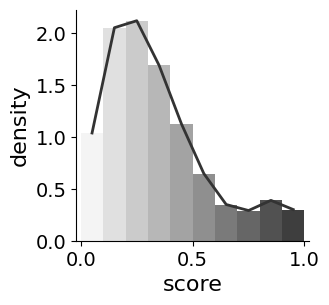

In [6]:
intrinsic_base_dataset.classifier_score_distribution = intrinsic_base_dataset.infer_classifier_score_distribution(num_bin=10)
intrinsic_base_dataset.classifier_score_distribution.plot()

In [7]:
# ground truth prevalence
Counter(intrinsic_gt_label_dict.values())["pos"] / num_base_size

0.1

### 1.2 Subsample calibration sample

In [8]:
num_sample = 1500

array([<AxesSubplot:title={'center':'Class Conditional Densities'}, xlabel='score', ylabel='density'>,
       <AxesSubplot:title={'center':'Label Density'}>,
       <AxesSubplot:title={'center':'Joint Density'}, xlabel='score', ylabel='density'>,
       <AxesSubplot:title={'center':'Classifier Score Density'}, xlabel='score', ylabel='density'>,
       <AxesSubplot:title={'center':'Calibration Curve'}, xlabel='$C(x)$', ylabel='$P(y=1|C(x))$'>],
      dtype=object)

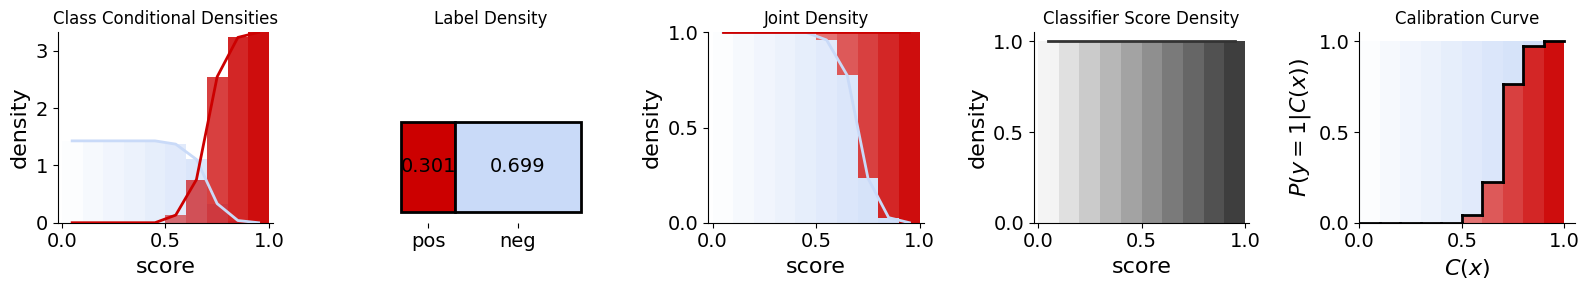

In [9]:
# 2. Select a subset of the dataset and annotate the labels
intrinsic_selected_dataset, intrinsic_selection_weights = (
    intrinsic_base_dataset.select_sample_for_annotation(
        n=num_sample, strategy="uniform", bins=num_bin
    )
)
annotated_labels = [
    intrinsic_gt_label_dict[uid]
    for uid in intrinsic_selected_dataset.df["uid"].values.astype(int)
]
intrinsic_selected_dataset.annotate_sample(annotated_labels)

intrinsic_selected_dataset.profile_dataset()

### 1.3 Estimate calibration curve from calibration sample

In [10]:
intrinsic_selected_dataset.df.head(10)

uid gt_label     p_pos     p_neg
bin                                            
0   71980  71980.0      neg  0.069298  0.930702
    83251  83251.0      neg  0.035504  0.964496
    95941  95941.0      neg  0.032849  0.967151
    57474  57474.0      neg  0.082019  0.917981
    96055  96055.0      neg  0.062466  0.937534
    69568  69568.0      neg  0.078905  0.921095
    59073  59073.0      neg  0.036251  0.963749
    78612  78612.0      neg  0.060484  0.939516
    83010  83010.0      neg  0.045803  0.954197
    90379  90379.0      neg  0.089141  0.910859

In [11]:
binning_calibration_curve = intrinsic_selected_dataset.calibration_curve

In [12]:
intrinsic_selected_dataset.update_calibration_curve(method="platt scaling")
ps_calibration_curve = intrinsic_selected_dataset.calibration_curve

# estimated_w, estimated_b = ps_calibration_curve.get_params()
# estimated_w = estimated_w.item()
# estimated_b = estimated_b.item()

# print(f"Estimated w: {estimated_w}, Estimated b: {estimated_b}")

In [13]:
# intrinsic_selected_dataset.update_calibration_curve(method="temperature scaling")
# temperature_calibration_curve = intrinsic_selected_dataset.calibration_curve

In [14]:
# temperature_calibration_curve.plot()

In [15]:
# temperature_calibration_curve.get_calibrated_probs(temperature_calibration_curve.x_axis)

In [16]:
intrinsic_selected_dataset.update_calibration_curve(method="mid piecewise linear")
mid_piecewise_linear_calibration_curve = intrinsic_selected_dataset.calibration_curve

In [17]:
intrinsic_selected_dataset.update_calibration_curve(method="mean piecewise linear")
mean_piecewise_linear_calibration_curve = intrinsic_selected_dataset.calibration_curve

In [18]:
intrinsic_selected_dataset.update_calibration_curve(method="isotonic regression")
isotonic_calibration_curve = intrinsic_selected_dataset.calibration_curve

### 1.4 Show plots, including Prevalence estimation

In [19]:
labels = ['pos', 'neg']

estimated prevalence: 0.10066386666666663
[0.         0.         0.         0.         0.         0.04
 0.22666667 0.76666667 0.97333333 1.         1.        ]
estimated prevalence: 0.1010143392693484
[0.         0.         0.         0.         0.         0.02
 0.13333333 0.49666667 0.87       0.98666667 1.        ]
estimated prevalence: 0.10197619457151913
[0.         0.         0.         0.         0.         0.02270809
 0.14563457 0.50319634 0.86450754 0.98851106 1.        ]
estimated prevalence: 0.11111861797541418
[2.17337458e-04 7.26168006e-04 2.42338530e-03 8.05540242e-03
 2.64296125e-02 8.31997071e-02 2.32757350e-01 5.03508094e-01
 7.72216938e-01 9.18916148e-01 9.74283018e-01]
estimated prevalence: 0.10036656680389743
[0.         0.         0.         0.         0.         0.
 0.08791209 0.39393939 0.94202899 1.         1.        ]


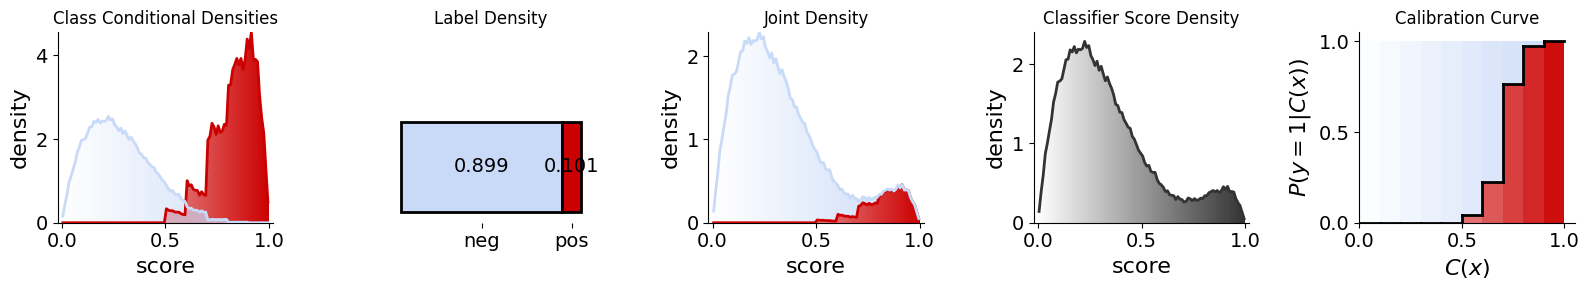

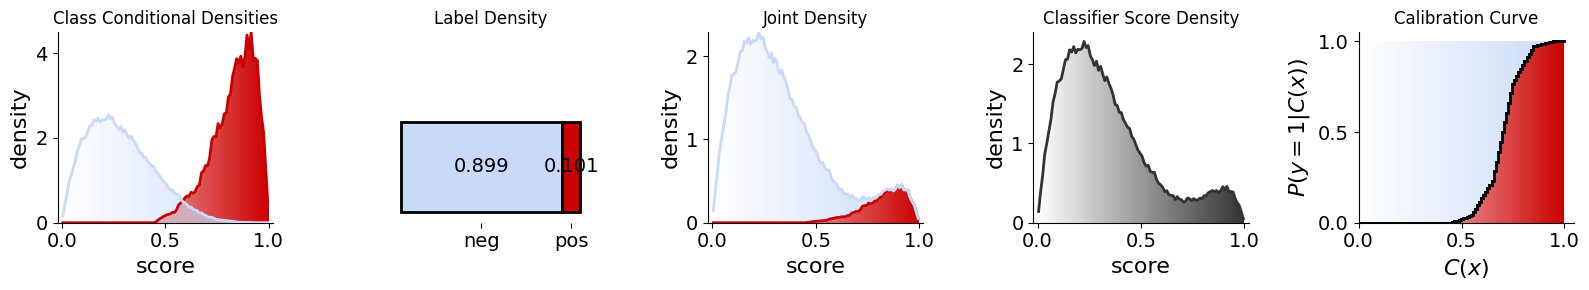

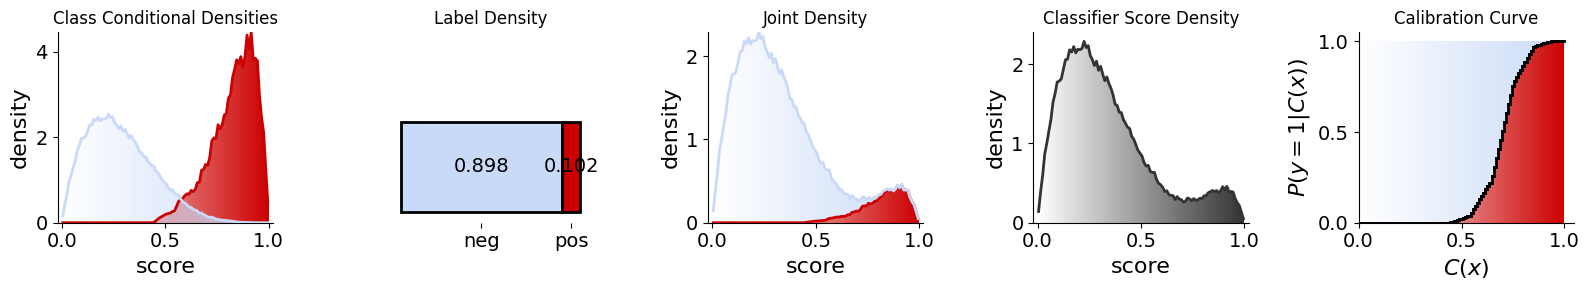

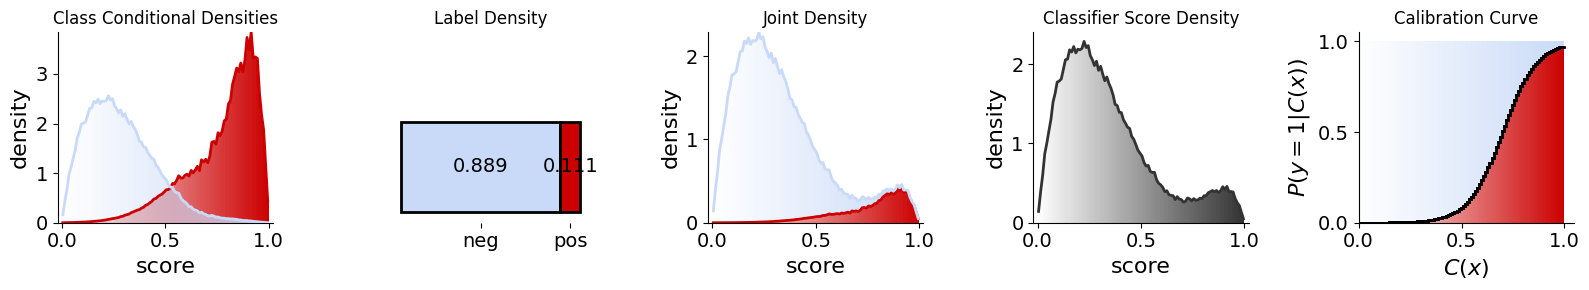

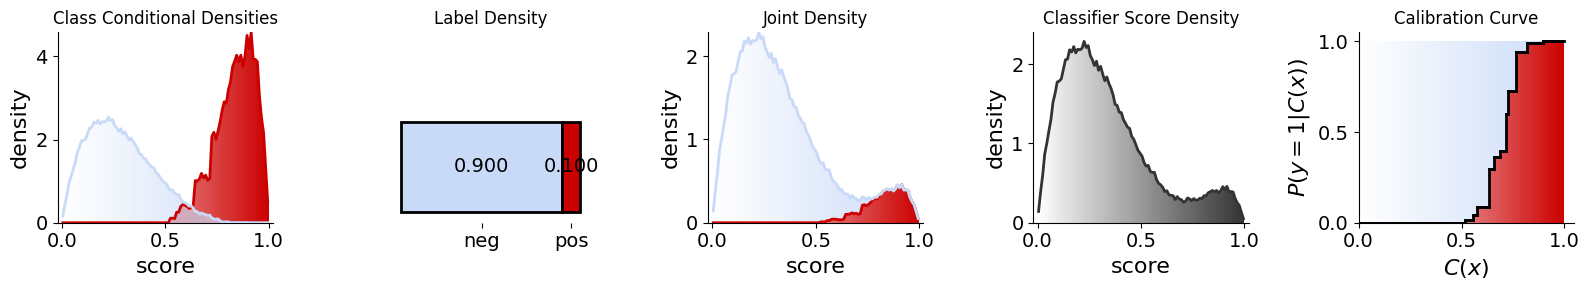

In [20]:
intrinsic_base_dataset.classifier_score_distribution = intrinsic_base_dataset.infer_classifier_score_distribution(num_bin=100)

for cc in [
    binning_calibration_curve,
    mid_piecewise_linear_calibration_curve,
    mean_piecewise_linear_calibration_curve,
    ps_calibration_curve,
    # temperature_calibration_curve,
    isotonic_calibration_curve,
]:
    jd = ExtrinsicJointDistribution(labels, intrinsic_base_dataset.classifier_score_distribution, cc)
    print('estimated prevalence:', intrinsic_base_dataset.extrinsic_estimate(calibration_curve=cc))
    print(cc.get_calibrated_probs(np.linspace(0, 1, 11)))
    jd.plot_five_distributions()